# **Soft SVMs**

Laboratory 4 of the Machine Learning class held by Prof. F. Chiariotti during academic year 2024-2025.

In [1]:
# importing all the necessary python libraries
import numpy as np
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

# **Classification of Stayed/Churned Customers**

The Customer Churn table contains information on all 3,758 customers from a Telecommunications company in California in Q2 2022. We want to use this task to predict if a customer will churn (i.e. turn to another company to get a better deal) or not based on three features. It contains three features:
- **Tenure** (in Months) Number of months the customer has stayed with the company
- **Monthly Charge**: The amount charged to the customer monthly
- **Age**: Customer's age
- **Customer Status**:  is 0 if the customer has stayed with the company and 1 if the customer has churned.

In [2]:
np.random.seed(1) # setting the seed

def load_dataset(filename):
    # function that loads the csv file and splits the dataset between input and labels, while also
    # shuffling the data and shifting the label range from [0,1] to [-1,1] (-1 = stayed, +1 = churned)
    data_train = pd.read_csv(filename)
    data_train = data_train.sample(frac=1).reset_index(drop=True) # shuffling
    X = data_train.iloc[:, 0:3].values 
    Y = data_train.iloc[:, 3].values 
    Y = 2*Y-1 #
    return X,Y

# Load the dataset
X, Y = load_dataset('data/telecom_customer_churn_cleaned.csv')

In [3]:
# splitting the data into training and test sets
m_training = int(0.75*X.shape[0]) # computing the split
m_test =  X.shape[0] - m_training
X_training =  X[:m_training] # splitting
Y_training =  Y[:m_training]
X_test =   X[m_training:]
Y_test =  Y[m_training:]
print("# of samples in the train set:", X_training.shape[0])
print("# of samples in the test set:", X_test.shape[0])
print("# of churned users in test:", np.sum(Y_test==-1))
print("# of loyal users in test:", np.sum(Y_test==1))

# standardizing the tests by computing a transformation on the training input set
scaler = preprocessing.StandardScaler().fit(X_training)  
np.set_printoptions(suppress=True) # setting to zero floating point numbers < min_float_eps
# and appling the transformation to both training and test sets
X_training =  scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))
X_test =  scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

# of samples in the train set: 2817
# of samples in the test set: 940
# of churned users in test: 479
# of loyal users in test: 461
Mean of the training input data: [-0.  0. -0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [0.0575483  0.05550169 0.0073833 ]
Std of the test input data: [0.98593187 0.97629659 1.00427583]


We will use **homogeneous coordinates** to describe all the coefficients of the model.

_Hint:_ The conversion can be performed with the function $hstack$ in $numpy$.

In [4]:
def to_homogeneous(X_training, X_test):
    # function that transforms from inhomogheneous coordinates to homogeneous ones
    Xh_training = np.hstack([np.ones( (X_training.shape[0], 1) ), X_training])
    Xh_test = np.hstack([np.ones( (X_test.shape[0], 1) ), X_test])
    return Xh_training, Xh_test

X_training, X_test = to_homogeneous(X_training, X_test)
print("some examples of training set in homogeneous coordinates are: ")
print(X_training[:10])

some examples of training set in homogeneous coordinates are: 
[[ 1.         -0.3798618  -1.57020044  0.85174963]
 [ 1.         -0.87925308  0.47180292  1.08667766]
 [ 1.         -0.75440526 -0.6130632  -0.26415851]
 [ 1.         -1.12894873  0.09856916 -0.96894261]
 [ 1.         -1.12894873 -0.58486332 -1.20387064]
 [ 1.          1.78416712  1.39908145  0.08823353]
 [ 1.         -0.7960212  -1.0990965  -0.32289052]
 [ 1.          0.20276137 -0.39907585 -0.96894261]
 [ 1.         -0.62955744  0.63934341  0.96921364]
 [ 1.         -0.87925308  1.13201197 -0.02923048]]


Now **complete** the function *sgd_soft_svm* and all auxiliary functions. <br>
You should select *a single sample*, compute the gradient, and run the soft SVM version (.

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the soft SVM
- $averaging\_iterations$: the number of iterations to consider when averaging

The output values are:
- $best\_w$: the vector with the coefficients of the best model
- $margin$: the *margin* of the best model
- $outliers$: the number of outliers that are classified correctly by the best model
- $misclassified$: the number of outliers that are misclassified by the best model

In [5]:
def count_outliers(current_w, X, Y):
    # function that finds the number of outliers and the number of misclassified samples
    Y_pred = np.dot(X, current_w)
    margin = Y_pred * Y
    outliers = np.where(margin < 1)[0]
    misclassified = np.where(margin < 0)[0]
    no = len(outliers)
    nm = len(misclassified)
    return no, nm

def find_margin(current_w):  
    # function that computes the margin of the model based on the input weights
    norm = np.sqrt(np.sum(np.asarray(current_w) ** 2))
    return 1 / np.max([1e-9, norm])

def sgd_soft_svm(X, Y, lambda_par, max_num_iterations, averaging_iterations):
    # function that trains the soft SVM on the training set (X, Y) for an input number 
    # of maximum iterations and an input softness parameter lambda
    # the SGD part of the algorithm cancels out fluctuations by averaging the weights
    # over the last few iterations (given by averaging_iterations)

    theta = np.zeros(X.shape[1]) # initializing the weights
    best_w = np.zeros(X.shape[1])
    num_samples = X.shape[0]

    # changing the weights with SGD
    for num_iter in range(max_num_iterations):
        # Compute the current weights
        curr_w = theta / lambda_par / (num_iter + 1)
        # Compute the gradient over a random point
        idx = rnd.sample(range(num_samples), 1)[0]
        if (np.dot(X[idx, :], curr_w) * Y[idx] < 1):
            theta += Y[idx] * X[idx, :]
        if (num_iter >= max_num_iterations - averaging_iterations):
            # in the last few iterations, we average to cancel out fluctuation
            best_w += curr_w / averaging_iterations

    margin = find_margin(best_w) # finding the quantities for the next step
    outliers, misclassified = count_outliers(best_w, X, Y)
    return best_w, margin, outliers, misclassified

Now we use the implementation to learn a model from the training data using 100000 iterations and averaging over the last 10000. Let us consider $\lambda=1$. Then we use the best model $best\_w$ to **predict the labels for the test dataset** and print the fraction of outliers in the test set (the test error that is an estimate of the true loss).

In [6]:
# running the Soft SVM with:
# - lambda=0.1
# - 100000 SGD iterations
# - 10000 SGD averaging iterations
best_w, margin, outliers, misclassified = sgd_soft_svm(X_training, Y_training, 0.1, int(1e5), int(1e4))
print("Soft SVM: ")
print('best parameters: ', best_w)
print("margin: ", margin)
print("fraction of training outliers: ", outliers/len(Y_training))
print("fraction of misclassified training samples: ", misclassified)
true_error = np.asarray(count_outliers(best_w, X_test, Y_test)) / len(Y_test)
print("fraction of test outliers: " + str(true_error[0]))
print("fraction of misclassified test samples: " + str(true_error[1]))

Soft SVM: 
best parameters:  [ 0.02940684 -0.90009047  0.39762473  0.13493369]
margin:  1.0063906671030347
fraction of training outliers:  0.6897408590699325
fraction of misclassified training samples:  736
fraction of test outliers: 0.7074468085106383
fraction of misclassified test samples: 0.25638297872340426


Now let us compare the result with your perceptron function from Lab 2.

In [7]:
def count_errors(current_w, X, Y):
    # function that finds all indices which have a different sign from the corresponding labels
    index = np.nonzero(np.sign(np.dot(X, current_w)) - Y)[0]
    n = np.array(index).shape[0]
    if (n == 0): # when there are no misclassified samples
        return 0, -1
    return n, index

In [8]:
def perceptron_randomized_update(current_w, X, Y):
    # function that updates the perceptron weights
    new_w=current_w
    n, idx = count_errors(current_w, X, Y)
    # Choose a random misclassified sample
    if (n > 0):
        chosen = rnd.sample(sorted(idx), 1)[0]
        new_w = current_w + Y[chosen] * X[chosen,:]
    return new_w

def perceptron_with_randomization(X, Y, max_num_iterations):
    # function that implements the random perceptron on a dataset (X,Y) and
    # imposes a maximum number of iterations as a termination condition 
    num_samples = X.shape[0] # initializing support variables
    num_iter = 0
    curr_w = np.zeros(X.shape[1]) # initializing the perceptron weights 
    # compute the number of misclassified samples and their indexes
    num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
    best_error = num_misclassified / num_samples # computing the initial error
    best_w = curr_w.copy() # initalizing the model
    # iterating until all samples are correctly classified or until the termination condition is met
    while num_misclassified != 0 and num_iter < max_num_iterations:
        curr_w = perceptron_randomized_update(curr_w, X, Y)
        num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
        if num_misclassified / num_samples < best_error:
            # computing the error as the fraction of misclassified samples if a better model is found
            best_error = num_misclassified / num_samples
            best_w = curr_w.copy()
        num_iter += 1
    # returning the best model and the corresponding error
    return best_w, best_error

In [9]:
# comparing the performances of Soft SVM with Perceptron for 1000 iterations
w_found, error = perceptron_with_randomization(X_training, Y_training, 1000)
print('Perceptron: ')
print("training error: ", error)
print("best parameters: ", w_found)
true_loss_estimate =  count_errors(w_found, X_test, Y_test)[0] / len(Y_test)      
print("fraction of misclassified samples: ", true_loss_estimate)

Perceptron: 
training error:  0.24494142705005326
best parameters:  [ 0.         -2.37210862  1.38511195  0.82224811]
fraction of misclassified samples:  0.2553191489361702


## **Soft SVM K-fold cross validation**
To see the effect of $\lambda$, we run k-fold cross validation for different values of $$\lambda: $10, 1, 0.1, 0.01, 0.001$ and run a K-fold cross validation (you can use the code from Lab 3), using the loss (i.e. the number of misclassified points) as a score.

In [10]:
def K_fold(X_training: np.ndarray, Y_training: np.ndarray, lambda_par: np.ndarray, K: np.ndarray) -> None:
    # function that performs k-fold cross validation on the training data 
    # (X_training, Y_training) for an input K and for given values of the 
    # regularization parameter lambda

    best = -1 # initializing
    best_perf = 1e20
    results = []
    models = []
    max_idx = np.shape(Y_training)[0]

    perm = np.arange(0, np.shape(X_training)[0], 1) # permutating
    rnd.shuffle(perm)
    X_shuffled = np.asarray(X_training[perm, :])
    Y_shuffled = np.asarray(Y_training[perm])

    fold_points = int(np.floor(max_idx / K)) # splitting the training set in K folds
    for lambda_idx in range(len(lambda_par)): # for every value of lambda
        lambda_perf = 0
        # training and validating are performed for each lambda value
        for test in range(K):
            # training on all folds but one
            x_train_fold = np.concatenate([X_shuffled[: fold_points * test, :], X_shuffled[fold_points * (test + 1) + 1 :, :]])
            y_train_fold = np.concatenate([Y_shuffled[: fold_points * test], Y_shuffled[fold_points * (test + 1) + 1 :]])
            k_model, k_margin, k_out, k_misc = sgd_soft_svm(x_train_fold, y_train_fold, lambda_par[lambda_idx], int(1e5), int(1e4))
            # testing on the remaining fold
            x_validate_fold = X_shuffled[fold_points * test : fold_points * (test + 1) + 1, :]
            y_validate_fold = Y_shuffled[fold_points * test : fold_points * (test + 1) + 1]
            lambda_perf += count_outliers(k_model, x_validate_fold, y_validate_fold)[1] / len(y_validate_fold)
        lambda_perf /= K
        results.append(lambda_perf)
        models.append(sgd_soft_svm(X_shuffled, Y_shuffled, lambda_par[lambda_idx], int(1e5), int(1e4)))
        if (best_perf > lambda_perf): # if better results are found, we update the bests
            best = sgd_soft_svm(X_shuffled, Y_shuffled, lambda_par[lambda_idx], int(1e5), int(1e4))
            best_perf = lambda_perf
    return best, best_perf, models, results

In [14]:
# running the training with K-fold cross-validation for different lambdas
K = 5
lambda_par = [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
best_model, best_perf, models, results = K_fold(X_training, Y_training, lambda_par, K)
print('the best SVM parameters found are: ', best_model)
print('the best SVM is found for lambda = ', best_perf)
training_error = np.asarray(count_outliers(best_model[0], X_training, Y_training)) / len(Y_training)
print("best lambda value performance on the training set: ")
print("fraction of outliers: " + str(training_error[0]))
print("fraction of misclassified samples: " + str(training_error[1]))

the best SVM parameters found are:  (array([-0.11354883, -1.35393355,  0.75154894,  0.22966596]), 0.6371104896862763, 1483, 696)
the best SVM is found for lambda =  0.24609929078014187
best lambda value performance on the training set: 
fraction of outliers: 0.5264465743698971
fraction of misclassified samples: 0.2470713525026624


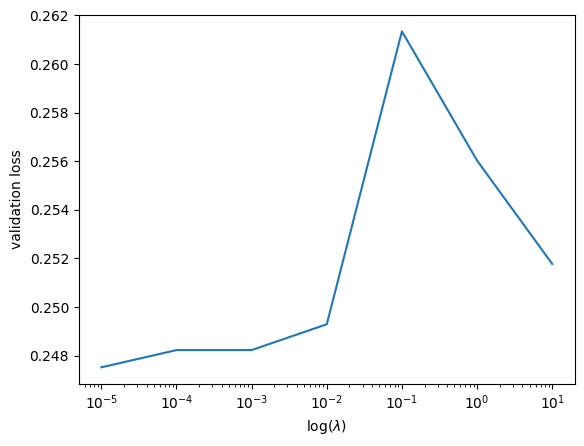

In [12]:
# plotting the results
plt.plot(lambda_par, results)
plt.xscale('log')
plt.xlabel('$\log(\lambda)$')
plt.ylabel('validation loss')
plt.show()

In [13]:
true_error = np.asarray(count_outliers(best_model[0], X_test, Y_test)) / len(Y_test)
print("best lambda value performance on the test set: ")
print("fraction of outliers: " + str(true_error[0]))
print("fraction of misclassified samples: " + str(true_error[1]))

best lambda value performance on the test set: 
fraction of outliers: 0.3627659574468085
fraction of misclassified samples: 0.2425531914893617
